## Blending Degrader demo

author: Shuang Liang

This notebook demonstrate the use of `rail.creation.degradation.unrec_bl_model`, which uses Friends of Friends to finds sources close to each other and merge them into unrecognized blends

In [2]:
from rail.creation.degraders.unrec_bl_model import UnrecBlModel

from rail.core.data import PqHandle
from rail.core.stage import RailStage

import tables_io
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

### Create a random catalog with ugrizy+YJHF bands as the the true input

In [ ]:
data = np.random.normal(24, 3, size = (1000,13))
data[:, 0] = np.random.uniform(low=0, high=0.03, size=1000)
data[:, 1] = np.random.uniform(low=0, high=0.03, size=1000)
data[:, 2] = np.random.uniform(low=0, high=2, size=1000)

data_df = pd.DataFrame(data=data,    # values
            columns=['ra', 'dec', 'z_true', 'u', 'g', 'r', 'i', 'z', 'y', 'Y', 'J', 'H', 'F'])
data_truth = data_df

In [ ]:
#data_df.to_parquet('bl_test.pq')

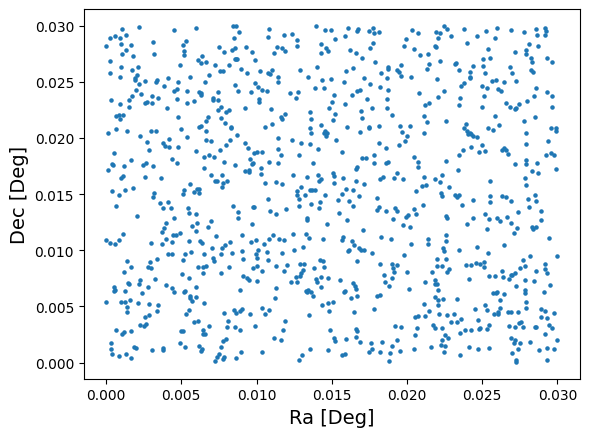

In [5]:
plt.scatter(data_truth['ra'], data_truth['dec'], s=5)
plt.xlabel("Ra [Deg]", fontsize=14)
plt.ylabel("Dec [Deg]", fontsize=14)
plt.show()


### The blending model

In [6]:
## model configuration; linking length is in arcsecs

lsst_zp_dict = {'u':12.65, 'g':14.69, 'r':14.56, 'i': 14.38, 'z':13.99, 'y': 13.02}
blModel = UnrecBlModel.make_stage(name='unrec_bl_model', ra_label='ra', dec_label='dec', linking_lengths=1.0, \
                                  bands='ugrizy', zp_dict=lsst_zp_dict, 
                                  ref_band = 'i', redshift_col = 'z_true')
blModel.get_config_dict()


{'output_mode': 'default',
 'seed': 12345,
 'ra_label': 'ra',
 'dec_label': 'dec',
 'linking_lengths': 1.0,
 'bands': ['u', 'g', 'r', 'i', 'z', 'y'],
 'zp_dict': {'u': 12.65,
  'g': 14.69,
  'r': 14.56,
  'i': 14.38,
  'z': 13.99,
  'y': 13.02},
 'ref_band': 'i',
 'redshift_col': 'z_true',
 'match_size': False,
 'match_shape': False,
 'obj_size': 'obj_size',
 'a': 'semi_major',
 'b': 'semi_minor',
 'theta': 'orientation',
 'name': 'unrec_bl_model',
 'config': None}

In [7]:
# run the model

outputs = blModel(data_truth)

samples_w_bl = outputs['output'].data
component_ind = outputs['compInd'].data


Inserting handle into data store.  input: None, unrec_bl_model
Inserting handle into data store.  output_unrec_bl_model: inprogress_output_unrec_bl_model.pq, unrec_bl_model
Inserting handle into data store.  compInd_unrec_bl_model: inprogress_compInd_unrec_bl_model.pq, unrec_bl_model


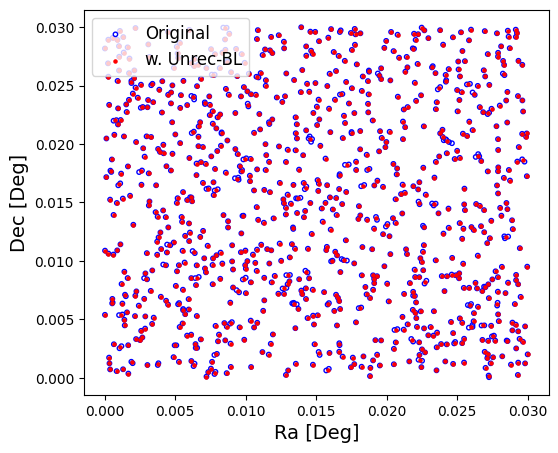

In [8]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax.scatter(data_truth['ra'],   data_truth['dec'],   s=10, facecolors='none', edgecolors='b', label='Original')
ax.scatter(samples_w_bl['ra'], samples_w_bl['dec'], s=5, c='r', label='w. Unrec-BL')

ax.legend(loc=2, fontsize=12)
ax.set_xlabel("Ra [Deg]", fontsize=14)
ax.set_ylabel("Dec [Deg]", fontsize=14)

plt.show()


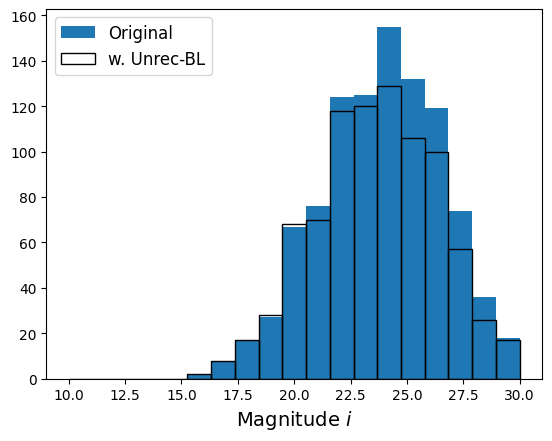

In [9]:
b = 'i'
plt.hist(data_truth[b], bins=np.linspace(10, 30, 20), label='Original')
plt.hist(samples_w_bl[b], bins=np.linspace(10, 30, 20),  fill=False, label='w. Unrec-BL')

plt.xlabel(fr'Magnitude ${b}$', fontsize=14)
plt.legend(fontsize=12)
plt.show()


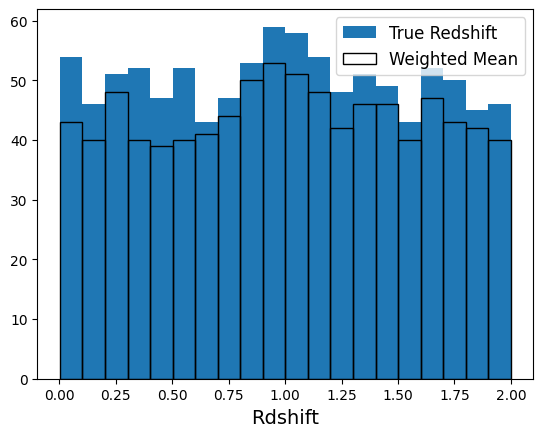

In [ ]:

plt.hist(data_truth['z_true'], bins=20, label='True Redshift')
plt.hist(samples_w_bl['z_weighted'], bins=20,  fill=False, label='Weighted Mean')

plt.xlabel(fr'Redshift', fontsize=14)
plt.legend(fontsize=12)
plt.show()


### Study one BL case

In [11]:
## find a source with more than 1 truth component

group_size = 1
while group_size==1:

    rand_ind = np.random.randint(len(samples_w_bl))
    this_bl = samples_w_bl.iloc[rand_ind]
    group_id = this_bl['group_id']

    mask = (component_ind['group_id'] == group_id)
    FoF_group = component_ind[mask]
    group_size = len(FoF_group)

truth_comp = data_truth.iloc[FoF_group.index]

print('Truth RA / Blended RA:')
print(truth_comp['ra'].to_numpy(), '/', this_bl['ra'])
print("")

print('Truth DEC / Blended DEC:')
print(truth_comp['dec'].to_numpy(), '/', this_bl['dec'])
print("")

for b in 'ugrizy':
    print(f'Truth mag {b} / Blended mag {b}:')
    print(truth_comp[b].to_numpy(), '/', this_bl[b])
    print("")
    

Truth RA / Blended RA:
[0.00189045 0.00189742] / 0.0018939360206937982

Truth DEC / Blended DEC:
[0.02538846 0.02521153] / 0.0252999942859987

Truth mag u / Blended mag u:
[24.52764942 24.15950254] / 23.57547146065513

Truth mag g / Blended mag g:
[24.89978462 21.61947484] / 21.567806349618618

Truth mag r / Blended mag r:
[23.89269227 25.21534579] / 23.61138132960144

Truth mag i / Blended mag i:
[26.57511224 24.82877486] / 24.63064040048841

Truth mag z / Blended mag z:
[25.38567128 23.08612651] / 22.962813093565835

Truth mag y / Blended mag y:
[23.71793466 24.13990692] / 23.155973557475296



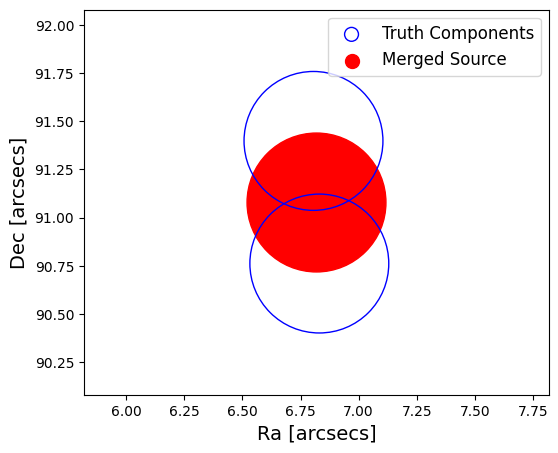

In [12]:

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax.scatter(this_bl['ra']*3600, this_bl['dec']*3600, s=1e4, c='r')
ax.scatter(truth_comp['ra']*3600, truth_comp['dec']*3600, s=1e4, facecolors='none', edgecolors='b')

ax.scatter([], [], s=1e2, facecolors='none', edgecolors='b', label='Truth Components')
ax.scatter([], [], s=1e2, c='r', label='Merged Source')

fig_size = 1   ## in arcsecs
ax.set_xlim(this_bl['ra']*3600-fig_size, this_bl['ra']*3600+fig_size)
ax.set_ylim(this_bl['dec']*3600-fig_size, this_bl['dec']*3600+fig_size)

ax.legend(fontsize=12)
ax.set_xlabel("Ra [arcsecs]", fontsize=14)
ax.set_ylabel("Dec [arcsecs]", fontsize=14)

plt.show()
